# Hyperparameter Tuning Vertex AI for Image Classification
In this lab you will use hyperparams tuning on Vertex AI to train and tune an Image Classification model.

**Learning Objectives:**
* Learn how to develop an efficient ingest pipeline for images serialized to TFRecords with `tf.data`
* Learn how to configure a training application for Vertex AI Hyperparameter Tuning
* Learn how to launch a hyperparameter tuning job

## Setup 

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
from google.cloud import aiplatform
from google.cloud.aiplatform import hyperparameter_tuning as hpt

print(tf.__version__)

2.12.0


In [2]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT
TRAIN_DATA_PATH = f"gs://{BUCKET}/flowers/data/train*"
EVAL_DATA_PATH = f"gs://{BUCKET}/flowers/data/eval*"
REGION = "us-central1"
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

%env BUCKET={BUCKET}
%env PROJECT={PROJECT}
%env REGION={REGION}

env: BUCKET=kylesteckler-instructor
env: PROJECT=kylesteckler-instructor
env: REGION=us-central1


#### Data Setup

The next two cells make sure your bucket exists (or creates it) then copies the `.tfrecord` files to your bucket.

Make sure bucket exists and if not, create it.

In [3]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
  echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Bucket gs://kylesteckler-instructor already exists.


Copy data to your bucket

In [4]:
!gsutil -m cp gs://asl-public/data/flowers/tfrecords/* gs://{BUCKET}/flowers/data/

Copying gs://asl-public/data/flowers/tfrecords/eval.tfrecord-00000-of-00003 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/eval.tfrecord-00001-of-00003 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/eval.tfrecord-00002-of-00003 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/train.tfrecord-00000-of-00010 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/train.tfrecord-00001-of-00010 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/train.tfrecord-00002-of-00010 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/train.tfrecord-00003-of-00010 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfrecords/train.tfrecord-00009-of-00010 [Content-Type=application/octet-stream]...
Copying gs://asl-public/data/flowers/tfreco

Make sure the data is available

In [5]:
!gsutil ls {TRAIN_DATA_PATH}

gs://kylesteckler-instructor/flowers/data/train.tfrecord-00000-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00001-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00002-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00003-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00004-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00005-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00006-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00007-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00008-of-00010
gs://kylesteckler-instructor/flowers/data/train.tfrecord-00009-of-00010


In [6]:
!gsutil ls {EVAL_DATA_PATH}

gs://kylesteckler-instructor/flowers/data/eval.tfrecord-00000-of-00003
gs://kylesteckler-instructor/flowers/data/eval.tfrecord-00001-of-00003
gs://kylesteckler-instructor/flowers/data/eval.tfrecord-00002-of-00003


#### Create `tf.data` pipeline to ingest data

#### Data Ingest Pipeline
We can build a quite sophisticated ingest pipeline with two simple functions. We need a `create_dataset` function that returns a `tf.data` Dataset, and a `parse_example` function that parses each serialized Example.

The `create_dataset` function does the following:
* Gets a list of filenames that match a given pattern with `tf.io.gfile.glob`
* Instantiates a `tf.data.TFRecordDataset` with the list of filenames
* Maps a parsing function to each example
* Configures for performance with caching, shuffling, batching, and prefetching

The `parse_example` function does the following:
* Parses a single example using the `feature_description`
* Decodes the image with `tf.io.decode_jpeg`
* Resizes the image to specified shape (remember, all examples we feed through a neural network must have the same shape)
* Returns the image and the label

In [7]:
def parse_example(example, img_shape):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.io.decode_jpeg(example["image"], channels=3)
    return tf.image.resize(img, img_shape[:-1]) / 255.0, example["label"]


def create_dataset(pattern, batch_size, img_shape, mode="train"):
    AUTOTUNE = tf.data.AUTOTUNE
    filenames = tf.io.gfile.glob(pattern)  # List of files matching pattern
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(
        lambda x: parse_example(x, img_shape=img_shape),
        num_parallel_calls=AUTOTUNE,
    )

    # Configure for performance
    ds = ds.cache()
    if mode == "train":
        ds = ds.shuffle(buffer_size=10 * batch_size).repeat()
    else:
        ds = ds.repeat(1)

    return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

#### Validate data ingest pipeline
Ingest and inspect an example from both training and validation

2022-09-26 16:10:22.685561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-09-26 16:10:22.685616: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Example from training set:
Shape: (1, 256, 256, 3)
Label: daisy


2022-09-26 16:10:23.058514: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


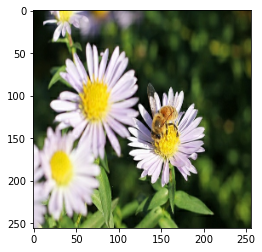

In [8]:
temp_train_ds = create_dataset(
    TRAIN_DATA_PATH, batch_size=1, img_shape=[256, 256, 3]
)
temp_val_ds = create_dataset(
    EVAL_DATA_PATH, batch_size=1, img_shape=[256, 256, 3], mode="test"
)

for img, label in temp_train_ds.take(1):
    print("Example from training set:")
    print(f"Shape: {img.shape}")
    print(f"Label: {CLASSES[int(label.numpy())]}")
    plt.imshow(tf.squeeze(img.numpy(), axis=0))

Example from validation set:
Shape: (1, 256, 256, 3)
Label: sunflowers


2022-09-26 16:10:23.481458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


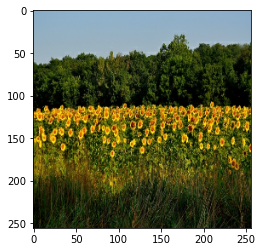

In [9]:
for img, label in temp_val_ds.take(1):
    print("Example from validation set:")
    print(f"Shape: {img.shape}")
    print(f"Label: {CLASSES[int(label.numpy())]}")
    plt.imshow(tf.squeeze(img.numpy(), axis=0))

#### Bundle code together for Vertex AI Hyperparameter Tuning
The steps to launch a hyperparameter tuning job with Vertex AI are:
* Make the hyperparameters you want to tune for command line arguments
* Report the metric you want to optimize with `hpt.report_hyperparameter_tuning_metric`
* Build and push containerized training application 
* Configure StudySpec for Vertex AI Hyperparameter Tuning
* Launch hyperparameter tuning job

In [10]:
!mkdir ./flower_trainer

mkdir: cannot create directory ‘./flower_trainer’: File exists


In [11]:
%%writefile ./flower_trainer/train.py

import fire
import hypertune
import tensorflow as tf
import tensorflow_hub as hub

MODULE_HANDLE = \
    'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'


def parse_example(example, img_shape):
    feature_description = {
        'image': tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.io.decode_jpeg(example['image'], channels=3)

    # resize and scale
    return tf.image.resize(img, img_shape[:-1])/255.0, example['label']


def create_dataset(
    pattern,
    batch_size,
    img_shape,
    mode='train'):
    AUTOTUNE = tf.data.AUTOTUNE

    filenames = tf.io.gfile.glob(pattern)  # List of files matching pattern
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(lambda x: parse_example(x, img_shape=img_shape),
                num_parallel_calls=AUTOTUNE)

    # Configure for performance

    ds = ds.cache()
    if mode == 'train':
        ds = ds.shuffle(buffer_size=10 * batch_size).repeat()
    else:
        ds = ds.repeat(1)

    return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)


def build_hub_model(
    input_shape,
    dense_units,
    dropout,
    num_classes,
    module_handle,
    ):

    inputs = tf.keras.layers.Input(shape=input_shape) # [height, width, channels]

    # Pre-trained model from tfhub
    # trainable=False means frozen weights
    hub_layer = hub.KerasLayer(module_handle, trainable=False)(inputs)

    # Additional learned dense layer
    dense_layer = tf.keras.layers.Dense(
        dense_units, activation='relu')(hub_layer)
    
    x = tf.keras.layers.Dropout(dropout)(dense_layer)

    # Output the logits
    output = tf.keras.layers.Dense(num_classes)(x)

    # Instantiate keras model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model


def train_evaluate(
    train_data_path,
    eval_data_path,
    batch_size,
    num_steps,
    num_evals,
    img_shape=[224, 224, 3],
    dense_units=16,
    dropout=0.1,
    num_classes=5,
    module_handle=MODULE_HANDLE,
    hptune=True,
    output_dir=None):

    train_ds = create_dataset(train_data_path, batch_size=batch_size,
                              img_shape=img_shape)
    val_ds = create_dataset(eval_data_path, batch_size=64,
                            img_shape=img_shape, mode='test')

    steps_per_epoch = num_steps // (num_evals * batch_size)

    # Build model

    model = build_hub_model(input_shape=img_shape,
                            dense_units=dense_units, 
                            dropout=dropout,
                            num_classes=num_classes,
                            module_handle=module_handle)

    model.compile(optimizer='adam',
                  loss=tf.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=num_evals,
                        steps_per_epoch=steps_per_epoch, verbose=2)

    # report metric if tuning

    if hptune:
        hp_metric = history.history['val_accuracy'][-1]
        hpt = hypertune.HyperTune()
        hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag='accuracy', 
            metric_value=hp_metric, 
            global_step=num_evals)
    else:

    # save final model if not tuning

        model.save(output_dir)


if __name__ == '__main__':
    fire.Fire(train_evaluate)
    

Overwriting ./flower_trainer/train.py


#### Containerize training application

Write Dockerfile then build and push your image with `gcloud builds submit`

In [12]:
%%writefile ./flower_trainer/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-12.py310:latest

# Installs hypertune library and fire 
RUN pip install -U cloudml-hypertune fire tensorflow_hub

# Copies the trainer code to the docker image.
WORKDIR /app
COPY train.py .

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "train.py"]

Overwriting ./flower_trainer/Dockerfile


In [13]:
ARTIFACT_REGISTRY_DIR = "asl-artifact-repo"
IMAGE_NAME = "flowers_trainer_tf"
TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = (
    f"us-docker.pkg.dev/{PROJECT}/{ARTIFACT_REGISTRY_DIR}/{IMAGE_NAME}:{TAG}"
)
TRAINING_CONTAINER_IMAGE_URI

'us-docker.pkg.dev/takumiohym-sandbox/asl-artifact-repo/flowers_trainer_tf:latest'

In [14]:
!gcloud builds submit --machine-type=e2-highcpu-32 --timeout=15m --tag $TRAINING_CONTAINER_IMAGE_URI flower_trainer

Creating temporary tarball archive of 2 file(s) totalling 3.8 KiB before compression.
Uploading tarball of [flower_trainer] to [gs://takumiohym-sandbox_cloudbuild/source/1711033736.814066-a893ed7cd4d248c8b8d16dce3dc526ba.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/takumiohym-sandbox/locations/global/builds/3d846caf-71c0-4330-ae82-a57ab5a54cd8].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/3d846caf-71c0-4330-ae82-a57ab5a54cd8?project=237937020997 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "3d846caf-71c0-4330-ae82-a57ab5a54cd8"

FETCHSOURCE
Fetching storage object: gs://takumiohym-sandbox_cloudbuild/source/1711033736.814066-a893ed7cd4d248c8b8d16dce3dc526ba.tgz#1711033737115974
Copying gs://takumiohym-sandbox_cloudbuild/source/1711033736.814066-a893ed7cd4d248c8b8d16dce3dc526ba.tgz#1711033737115974...
/ [1 files][  1.8 KiB/  1.8 KiB]                                                
Operati

#### Configure Vertex AI Hyperparameter Tuning Job
There are configurations we need to provide Vertex AI with to launch a Hyperparameter Tuning job.

`worker_pool_specs` specifies the hardware and training application to run for each trial of the hyperparameter tuning job. `worker_pool_spec` is composed of `machine_spec` and `container_spec`. `machine_spec` defines the machine type you want Vertex to use, as well as (optionally) accelerator type and count. `container_spec` specifies the image URI of the containerized training application, as well as any arguments to pass along to it. Note: You only provide the arguments you are not hyperparameter tuning for.

`metric_spec` specifies the metric tag you want to optimize for as well as the optimization goal (minimize or maximize).

`parameter_spec` specifies the parameters you want to tune for as well as constaints for tuning them.

In [15]:
# Specify variables used to configure hyperparameter tuning job
TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")

DISPLAY_NAME = "flower-classifier-hyperparam-tuning-job"
MAX_TRIAL_COUNT = 10
MAX_PARALLEL_TRIALS = 5
JOB_NAME = f"flower-classifier-custom-training-{TIMESTAMP}"
BUCKET = f"gs://{PROJECT}"
NUM_STEPS = 10000
NUM_EVALS = 10

In [16]:
# Define required specifications
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-16",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAINING_CONTAINER_IMAGE_URI,
            "args": [
                f"--train_data_path={TRAIN_DATA_PATH}",
                f"--eval_data_path={EVAL_DATA_PATH}",
                f"--num_steps={NUM_STEPS}",
                f"--num_evals={NUM_EVALS}",
            ],
        },
    }
]

metric_spec = {"accuracy": "maximize"}

parameter_spec = {
    "batch_size": hpt.IntegerParameterSpec(min=16, max=128, scale="log"),
    "dense_units": hpt.DiscreteParameterSpec(values=[64, 128, 256], scale=None),
    "dropout": hpt.DoubleParameterSpec(min=0.05, max=0.4, scale="linear"),
}

custom_job = aiplatform.CustomJob(
    display_name=JOB_NAME,
    project=PROJECT,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=BUCKET,
)

# Create hyperparam tuning job
hp_job = aiplatform.HyperparameterTuningJob(
    display_name=JOB_NAME,
    custom_job=custom_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=MAX_TRIAL_COUNT,
    parallel_trial_count=MAX_PARALLEL_TRIALS,
    project=PROJECT,
    search_algorithm=None,
)

hp_job.run(sync=False)

INFO:google.cloud.aiplatform.jobs:Creating HyperparameterTuningJob


**NOTE** The job takes about 25 minutes to complete. Once the job is completed you can query the results and see metrics across the different trials.

In [18]:
for trial in hp_job.trials:
    print(f"Trial #{trial.id}")
    for param in trial.parameters:
        print(f"{param.parameter_id}: {param.value}")
    print(
        f"{trial.final_measurement.metrics[0].metric_id}: {trial.final_measurement.metrics[0].value}\n"
    )

Trial #1
batch_size: 72.0
dense_units: 128.0
dropout: 0.22500000000000003
accuracy: 0.8957476019859314

Trial #2
batch_size: 104.0
dense_units: 64.0
dropout: 0.14975153595671592
accuracy: 0.8724279999732971

Trial #3
batch_size: 44.0
dense_units: 256.0
dropout: 0.3053884473501118
accuracy: 0.8806584477424622

Trial #4
batch_size: 119.0
dense_units: 128.0
dropout: 0.23193908450446538
accuracy: 0.8875171542167664

Trial #5
batch_size: 25.0
dense_units: 128.0
dropout: 0.3952681990380913
accuracy: 0.8792867064476013

Trial #6
batch_size: 77.0
dense_units: 256.0
dropout: 0.4
accuracy: 0.8875171542167664

Trial #7
batch_size: 25.0
dense_units: 256.0
dropout: 0.2038999521531895
accuracy: 0.8875171542167664

Trial #8
batch_size: 128.0
dense_units: 64.0
dropout: 0.2260425651819189
accuracy: 0.8834019303321838

Trial #9
batch_size: 70.0
dense_units: 64.0
dropout: 0.19405110125906455
accuracy: 0.8861454129219055

Trial #10
batch_size: 59.0
dense_units: 256.0
dropout: 0.22130144744999003
accuracy:

Congrats! You've succesfully:
* Created a custom image classification model configured for Vertex AI Hyperparameter Tuning
* Built and pushed the training application as a Docker image
* Launched a Hyperparameter Tuning Job on Vertex AI 

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License